# LMS Exploration | 10. News_Summary_NLP

---

**[Introduce]**  

뉴스 내용을 읽고 헤드라인 기사를 생성주는 모델을 만들어보겠습니다.  
Text Summarization(텍스트 요약) 기법 중 Abstractive Summarization(추상적 요약) 접근법을 먼저 사용해보고,    
이후 Extractive Summarization(추출적 요약) 접근법을 사용해서 비교해보겠습니다.   
* 추상적 요약은 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것으로 자연어 생성(Natural Language Generation, NLG)의 영역입니다.
* 추출적 요약은 단어 그대로 원문에서 문장들을 추출해서 요약하는 방식으로 문장 분류(Text Classification) 문제로 볼 수 있습니다. 

**[Data]**  

* 98401개의 뉴스기사데이터를 사용합니다.  [News Summary Dataset](https://github.com/sunnysai12345/News_Summary)
* news_summary_more Dataset에는 총 98401개의 사례가 있는데, text와 headlines 의 정보를 포함합니다.
* text 열의 내용을 요약한 것이 headlines 입니다. 
* 추상적 요약을 하는 경우에는 text를 본문으로, headlines를 이미 요약된 데이터로 삼아서 모델을 학습합니다.
* 반면 추출적 요약을 하는 경우에는 오직 text열만을 사용합니다. 



## 라이브러리와 패키지 불러오기 
* 데이터 전처리 과정에서 NLTK의 불용어(stopwords)를 사용하여 불용어 제거 작업을 진행하기위해 nltk를 불러옵니다. 
* [NLTK](https://www.nltk.org/)는 Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리입니다.
* NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있습니다. 

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib.request

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 데이터 불러오기

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
#- 랜덤한 샘플 10개 출력
data.sample(10)
print(len(data))

98401


# 1. 추상적 요약

* text 시퀀스를 입력받으면, headlines 시퀀스를 예측하도록 인공신경망을 훈련시키고자 합니다. 

# 1-1. 데이터 전처리

* null 데이터 제거
* 중복 데이터 제거
* 텍스트 정규화
* 불용어 제거
* 훈련데이터와 테스트데이터 나누기
* 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
data[data['text'].duplicated()].head()

,headlines,text
20754,Aegon Life iTerm offers long-term care with en...,Safeguard yourself against life's unpleasant s...
44594,Berger introduces T20 of painting with Express...,Berger Paints has launched Berger Express Pain...
51012,Longest Test innings was longer than 10 footba...,Former Pakistani cricketer Hanif Mohammad batt...
52021,"Aus bowler took hat-trick in his 3rd ODI, neve...",Australia's Anthony Stuart took a hat-trick in...
53578,Lara named daughter after Sydney where he hit ...,Former Windies' captain Brian Lara named his f...


* headlines 는 간단한 요약들이 많아서  text 가 달라도 headlines 는 동일할 수 있습니다.
* 그러나 text 자체가 중복된 경우엔 중복 샘플이므로 제거해야 합니다.         

In [7]:
data.drop_duplicates(subset=['text'], inplace=True) #- inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
print('전체 샘플수:', (len(data)))

전체 샘플수: 98360


중복이 제거되면서 샘플의 수가 98360 개로 줄었지만, 여전히 Null 값을 가지는 데이터는 남아있을 수 있습니다.

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


확인해보니 null 값은 없습니다. 
98401 개의 전체 데이터에서 약 41개의 데이터가 제거되었습니다.

## 텍스트 정규화 (text normalization)
98360개의 단어중에는 같은 의미인데도 다른 표현으로 쓰여 다른 단어로 간주되는 경우가 있습니다.   
이러한 경우, 기계학습 전에 미리 같은 표현으로 통일시켜주어 기계의 연산량을 줄여줄 수 있습니다.   

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


## 불용어(stopwords)
일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 도움이 되지 않는 단어들이 존재합니다.  
NLRK에서 제공하는 불용어 리스트를 참조해 샘플에서 불용어를 제거하겠습니다.  
  
NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개 입니다. 이 외에도
* 모든 영어문자 소문자로 만들기
* 섞여 있는 hrml 태그 제거
* 정규표현식으로 각종 특수문자 제거하기 
등의 과정으로 필요한 내용만 학습시킬 수 있도록 데이터를 정제하겠습니다. 

**이때, text의 불용어는 제거하되, 기사의 짧은 헤드라인이 자연스러운 문장이 되기 위해서는 headlines에는 불용어를 남기는 것이 적절하다고 판단했습니다.** 

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
#- 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    #- 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) >1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens   

## 훈련 데이터 전체에 대한 전처리
* text 는 불용어를 제거하고, headlines는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행하겠습니다. 
* 멀티프로세싱을 활용하여 별도의 프로세스를 생성하여 병렬처리하면 CPU 수에 비례하여 획기적으로 소요시간을 줄일 수 있습니다.

In [12]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)

184.33993268013  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak pe

* headlines에 전처리 함수 호출 시, 불용어 제거를 수행하지 않는다는 의미에서 두번째 인자로 False를 넣어주었습니다.

In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

#- 빈 값을 Null 값으로 반환

data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

* 정제과정에서 모든 단어가 제거되어 빈 샘플이 생길 수 있기 때문에 확인해야 합니다. 
* NULL 값이 없음을 확인했습니다. 
* 아래는 만약 Null 값이 있는 경우, Null 값을 제거하는 코드입니다. 

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

## 훈련데이터와 테스트데이터 나누기
학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야합니다.  
샘플의 최대 길이를 정하기 위해, text와 headlines의 최소, 최대, 평균 길이를 구하고 길이분포를 시각화해보겠습니다.  

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


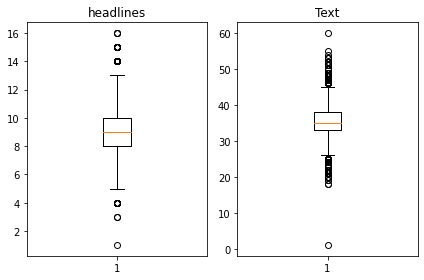

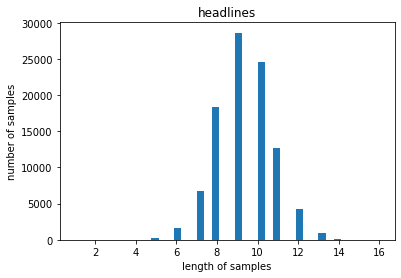

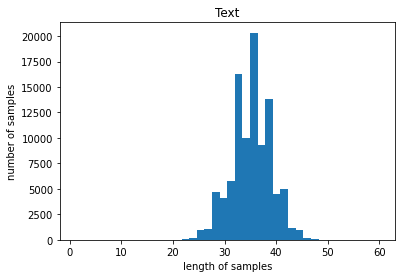

In [15]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 위에서부터 차례대로 그래프는 각각 요약과 실제 텍스트의 길이 분포, 요약본 샘플 길이별 개수, 실제 텍스트 셈플 길이별 개수를 나타냅니다. 
* text의 경우 최소 길이가 1, 최대 길이가 60 로 차이가 큰 편이지만, 평균 길이는 35로 시각화된 그래프로 봤을 땐 대체적으로 35 내외의 길이를 가진다는 것을 확인할 수 있습니다.
* headlines의 경우 최소 길이가 1, 최대 길이가 16, 평균 길이가 9로 text 에 비해 상대적으로 길이가 매우 짧습니다. 그래프로 봤을 때에도 대체적으로 9 내외의 길이를 가집니다.

* **위 정보로부터 text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 각각 38, 10으로 정했습니다.** 

In [16]:
text_max_len = 38
headlines_max_len = 10

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65295


## 시작 토큰과 종료 토큰 추가하기
* 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 것입니다.
* seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야 합니다.
* 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞뒤로 추가하겠습니다. 
* 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라 이름을 정하겠습니다. 

In [20]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


인코더의 입력, 디코더의 입력과 레이블을 각각 Numpy 타입으로 저장하겠습니다.

In [21]:
encoder_input = np.array(data['text']) #- 인코더의 입력
decoder_input = np.array(data['decoder_input']) #- 디코더의 입력
decoder_target = np.array(data['decoder_target']) #-디코더의 레이블

훈련 데이터와 테스트 데이터를 직접 분리하겠습니다.   
아래 랜덤한 정수 시퀀스를 이용해서 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플이 될 것입니다.   
잘 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리하겠습니다.  

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[18115 10309 39214 ... 35104 58166 52801]


In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13059


In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52236
훈련 레이블의 개수 : 52236
테스트 데이터의 개수 : 13059
테스트 레이블의 개수 : 13059


In [26]:
decoder_input_train

array(['sostoken oneplus announces exciting oneplus launch offers starting may',
       'sostoken veteran actor dilip kumar diagnosed with pneumonia',
       'sostoken centre slams un expert who criticised swachh bharat mission',
       ...,
       'sostoken us has lost mediator role in middle east turkish prez',
       'sostoken chose computer science over becoming mayor twitter ceo',
       'sostoken yr old computer built by steve jobs sells for crore'],
      dtype=object)

## 정수 인코딩 
단어 집합(vocabulary) 만들기 및 정수 인코딩의 작업을 하겠습니다.   
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 합니다.   

각 단어에 고유한 정수를 맵핑하는 작업이 필요한데,이 과정을 단어집합(Vocabulary)를 만든다고 표현합니다. 

* 훈련 데이터에 대한 단어집합을 만들어보겠습니다.  
* 우선적으로 원문에 해당하는 encoder_input_train에 대한 단어 집합을 만들겠습니다. 
* Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있습니다. 

### encoder_input_train 단어집합

In [27]:
src_tokenizer = Tokenizer() #- 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) #- 입력된 데이터로부터 단어 집합 생성

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다.  
현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있습니다.   
그런데 우리는 단어 집합에 있느 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들을 훈련 데이터에서 제외하고 진행하려고 합니다. 
  
* 등장 빈도수가 7회 미만은 단어들이 이 데이터에서 얼마만큼의 비중을 차지하는지 확인해보겠습니다.   
* src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있습니다.   

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) #- 단어의 수
rare_cnt = 0 #- 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 #- 훈련 데이터의 전체 단어 빈도수의 총 합 
rare_freq = 0 #- 등장 빈도수가 threshold 보다 작은 단어의 등장 빈도수의 합 

#- 단어와 빈도수의 쌍(pair)를 key와 value로 받는다

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    #- 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)        

단어 집합(vocabulary)의 크기 : 57367
등장 빈도가 6번 이하인 희귀 단어의 수: 39449
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17918
단어 집합에서 희귀 단어의 비율: 68.76601530496626
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.537751485166954


* encoder_input_train에는 약 5만7천개의 단어가 있습니다.
* 등장 빈도가 threshold 값은 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 70% 에 육박합니다. 
* 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 4.54% 밖에 되지 않습니다. 
* 이러한 단어들은 훈련에 큰 영향을 주지 않으면서 연산량을 차지하기 때문에, 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하겠습니다. 
* 위에서 이를 제외한 단어 집합의 크기를 17863개로 계산했는데 이와 비슷한 값으로 어림잡아 1만7천으로 제한해보겠습니다. 
* 토크나이저 정의 시 num_words 값을 정해주면, 단어 집합의 크기를 제한할 수 있습니다.


In [29]:
src_vocab = 17000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 17,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

* texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행합니다.

* 현재 단어 집합의 크기를 17,000으로 제한했으니까 이제 17,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않습니다.

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1991, 79, 1464, 5396, 1751, 583, 1991, 3913, 116, 4402, 4265, 4786, 1981, 1441, 11, 171, 260, 526, 199, 914, 1902, 1346, 4849, 5, 1309, 2611, 1051, 520, 191, 662, 7688, 520, 16650], [1843, 48, 4719, 206, 578, 72, 13229, 130, 8024, 3125, 14655, 10352, 185, 12581, 15557, 1, 66, 663, 441, 25, 156, 849, 7054, 10352, 1457, 3826, 825, 819, 1, 2, 14, 48, 185], [192, 392, 525, 3950, 12066, 361, 4556, 1287, 1134, 10007, 14656, 314, 508, 2221, 1, 30, 1956, 7373, 161, 4557, 3711, 1134, 314, 508, 7373, 9, 1, 2352, 689, 1752, 507, 254, 549]]


### decoder_input_train 단어집합
* Summary 데이터에 대해서도 동일한 작업을 수행합니다.
* 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산하겠습니다.

In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25873
등장 빈도가 6번 이하인 희귀 단어의 수: 18325
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7548
단어 집합에서 희귀 단어의 비율: 70.82673056854635
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.492913293784155


* 등장 빈도가 6회 이하인 단어들은 단어 집합에서 약 71%를 차지합니다.  
* 이하는 encoder_input_train의 단어집합 생성 과정과 동일합니다.
* 단어집합의 크기는 7000으로 정했습니다. 

In [33]:
tar_vocab = 7000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1201, 298, 6403, 1201, 224, 340, 3220, 97], [1, 2200, 184, 3112, 373, 3923, 9], [1, 198, 200, 207, 4935, 50, 2257, 3630, 823, 1155], [1, 2379, 3221, 1857, 747, 30, 4, 2755], [1, 3924, 1003, 142, 13, 140, 414, 768]]
target
decoder  [[1201, 298, 6403, 1201, 224, 340, 3220, 97, 2], [2200, 184, 3112, 373, 3923, 9, 2], [198, 200, 207, 4935, 50, 2257, 3630, 823, 1155, 2], [2379, 3221, 1857, 747, 30, 4, 2755, 2], [3924, 1003, 142, 13, 140, 414, 768, 2]]


* 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있습니다.
* 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높습니다.
* 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않습니다. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 것이라는 것을 주의해야 합니다. 
* 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해보겠습니다.

In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 52235
훈련 레이블의 개수 : 52235
테스트 데이터의 개수 : 13059
테스트 레이블의 개수 : 13059


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 패딩하기 
패딩작업은 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰줍니다.

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 1-2. 모델 설계하기
함수형 API를 이용해서 인코더를 설계합니다.

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

* 임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했습니다.

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

* 디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야합니다.

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# 어텐션 메커니즘
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있습니다.

In [39]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [40]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

* 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동합니다.

## 모델 훈련

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
205/205 [==============================] - 141s 632ms/step - loss: 6.4488 - val_loss: 5.7010
Epoch 2/50
205/205 [==============================] - 129s 628ms/step - loss: 5.6636 - val_loss: 5.4542
Epoch 3/50
205/205 [==============================] - 130s 632ms/step - loss: 5.3396 - val_loss: 5.2073
Epoch 4/50
205/205 [==============================] - 130s 635ms/step - loss: 5.0555 - val_loss: 5.0543
Epoch 5/50
205/205 [==============================] - 130s 633ms/step - loss: 4.8236 - val_loss: 4.8468
Epoch 6/50
205/205 [==============================] - 130s 636ms/step - loss: 4.6128 - val_loss: 4.6914
Epoch 7/50
205/205 [==============================] - 129s 631ms/step - loss: 4.4403 - val_loss: 4.6074
Epoch 8/50
205/205 [==============================] - 129s 631ms/step - loss: 4.2881 - val_loss: 4.5496
Epoch 9/50
205/205 [==============================] - 130s 633ms/step - loss: 4.1489 - val_loss: 4.4463
Epoch 10/50
205/205 [==============================] - 129s 629m

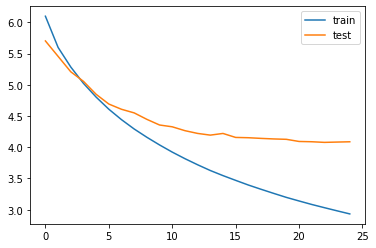

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

train loss : 2.8883  
val loss : 4.0875  

* 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비합니다.

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [44]:
tar_word_to_index['sostoken']

1

* seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 합니다. 
* 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 모델 하나만 준비합니다. 

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 실제 결과와 요약문 비교
* 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교합니다. 
* 아래는 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수입니다. 
* Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고   
  Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 합니다. 

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : wake billion fraud surfaced punjab national bank week reserve bank india said take appropriate action added assessment control systems pnb already undertaken rbi however denied reports pnb asked assume liabilities fraud 
실제 요약 : rbi to take action against fraud hit pnb 
예측 요약 :  bn pnb fraud case against iran


원문 : tata motors reportedly plan produce sports car showcased geneva motor show according report cost project evaluated crore considered company announced tata motors new sub brand car expected launched 
실제 요약 : tata motors kills plan to launch own sports car reports 
예측 요약 :  tata motors unveils electric cars in india


원문 : year old girl raped murdered year old neighbour saturday jharkhand dhanbad incident took place accused took victim marriage parents permission returned hour later without accused arrested sunday girl body recovered confessed crime interrogation 
실제 요약 : year old raped murdered by neighbour in jharkhand 
예측 요약 :  year old raped by girlfriend in uttar pr

50개 정도 데이터의 실제 요약과 예측 요약을 비교해 본 결과, 대부분의 경우,   
문맥이 맞지 않거나, 전체 내용을 포괄하지 못하는 일부의 내용을 가져오거나, 엉뚱한 내용요약을 하는 등 많이 미흡해보입니다.   

[엉뚱한 내용요약 사례]  
원문은 '뇌사 소년의 부모가 소년의 장기를 기증하기로 승인한 이후에 소년이 다시 깨어났다'는 기사인데, '심장병으로 소년이 죽었다'라는 엉뚱한 내용을 예측했습니다.   


        실제 요약 : brain dead boy wakes up after parents approve donation   
        예측 요약 :  year old boy dies after heart attack on

다음으로 비교적 난이도가 낮은 추출적 요약을 진행해보겠습니다.

# 2. 추출적 요약
* 동일한 데이터에 대해 Summa을 이용해서 추출적 요약을 해보겠습니다. 
* 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높은 반면,
* 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮습니다.  
* Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행하기 때문에 문장 구분이 되어 있지 않는 원문을 그래로 입력값으로 넣어줄 수 있습니다. 

In [50]:
! pip list | grep summa

summa                         1.2.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [51]:
import requests
from summa.summarizer import summarize

In [52]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data['news_summary'] = data['text'].apply(lambda x : summarize(x, ratio = 0.5))
data.head()

,headlines,text,news_summary
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...


In [53]:
pd.set_option('display.max_colwidth', None)
data[['headlines','news_summary']][:10]

,headlines,news_summary
0,upGrad learner switches to career in ML & Al with 90% salary hike,upGrad's Online Power Learning has powered 3 lakh+ careers.
1,Delhi techie wins free food from Swiggy for one year on CRED,"Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,"The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history."
3,Aegon life iTerm insurance plan helps customers save tax,"Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""In the #MeToo movement, I always believe a woman."
5,Rahat Fateh Ali Khan denies getting notice for smuggling currency,Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India.
6,"India get all out for 92, their lowest ODI total in New Zealand",India's previous lowest ODI total in New Zealand was 108.
7,Govt directs Alok Verma to join work 1 day before his retirement,"Weeks after ex-CBI Director Alok Verma told the Department of Personnel and Training to consider him retired, the Home Ministry asked him to join work on the last day of his fixed tenure as Director on Thursday."
8,Called PM Modi 'sir' 10 times to satisfy his ego: Andhra CM,"Andhra Pradesh CM N Chandrababu Naidu has said, ""When I met then US President Bill Clinton, I addressed him as Mr Clinton, not as 'sir'."
9,"Cong wins Ramgarh bypoll in Rajasthan, takes total to 100 seats","Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll."


원문 안의 단어를 추출하여 문장을 생성했기 때문에, 대부분의 출력문장이 (학습이 미흡한)추상적 요약에 비해 맥락에서 벗어나지 않아보입니다.    
그러나 새로운 문장을 생성할 수 있는 능력이 없기 때문에, 핵심문장을 센스있게 추상적 단어로 표현하지 못하고 단순한 사실의 나열이 되는 모습도 보입니다.    

그럼에도 불구하고, 추상적 요약을 성공적으로 학습시킬만한 적절한 데이터와 시간과 같은 자원이 충분하지 않은 경우, 비용과 성능의 측면을 고려했을 때, 오히려 간단한 추출적 요약 기법이 낫다고 생각됩니다. 

추상적 요약 모델과 텍스트 요약 모델을 문법의 완성도, 핵심단어의 포함측면으로 비교평가해볼때, 텍스트요약의 성능이 낫다고 판단되기 때문입니다. 

추상적 요약 모델의 성능을 개선하는 방법으로는
* seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법
* 빔 서치(beam search)
* 사전 훈련된 워드 임베딩(pre-trained word embedding)
* 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)

와 같은 여러 개선 방안들이 존재합니다. 